# 断続的時系列分析（ITS）パッケージ - 完全ウォークスルー

このノートブックでは、断続的時系列分析（Interrupted Time Series Analysis）パッケージの全機能を網羅的に解説します。

## 目次

1. **環境設定とデータ読み込み**
2. **データの前処理と可視化**
3. **モデル1: OLS回帰モデル**
   - モデルのフィッティング
   - 介入効果の推定
   - 可視化
4. **モデル2: SARIMAXモデル（Optunaチューニング）**
   - ハイパーパラメータチューニング
   - モデルのフィッティング
   - 介入効果の推定
5. **モデル3: Prophetモデル（Optunaチューニング）**
   - ハイパーパラメータチューニング
   - モデルのフィッティング
   - 介入効果の推定
6. **モデル検証: プラセボクロスバリデーション**
   - 単一介入のプラセボCV
   - 複数介入のプラセボCV
   - 感度分析
7. **結果の比較と解釈**
8. **レポート生成**

---

## 1. 環境設定とデータ読み込み

まず、必要なライブラリをインポートし、分析用のデータを読み込みます。

今回使用するのは、**Cigarデータセット**（タバコの販売に関する時系列データ）です。複数の介入（税率変更など）の効果を分析します。

In [1]:
# Generated By Github Copilot

import sys
from pathlib import Path
import warnings

# モジュールのインポートパス設定
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ITSモジュールのインポート
from module.its_analysis import (
    ITSDataPreprocessor,
    ITSModelOLS,
    ITSModelSARIMAX,
    ITSModelProphet,
    ITSVisualizer
)

# 警告を非表示
warnings.filterwarnings('ignore')

# プロット設定
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ ライブラリのインポート完了")

✅ ライブラリのインポート完了


In [2]:
# Cigarデータセットの読み込み
cigar = sm.datasets.get_rdataset("Cigar", "Ecdat").data

# データの概要を確認
print("📊 Cigarデータセットの概要")
print(f"データ形状: {cigar.shape}")
print(f"\nカラム: {list(cigar.columns)}")
print(f"\nデータ型:\n{cigar.dtypes}")
print(f"\n基本統計量:")
cigar.describe()

📊 Cigarデータセットの概要
データ形状: (1380, 9)

カラム: ['state', 'year', 'price', 'pop', 'pop16', 'cpi', 'ndi', 'sales', 'pimin']

データ型:
state      int64
year       int64
price    float64
pop      float64
pop16    float64
cpi      float64
ndi      float64
sales    float64
pimin    float64
dtype: object

基本統計量:


,state,year,price,pop,pop16,cpi,ndi,sales,pimin
count,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,26.826087,77.500000,68.699928,4537.113188,3366.616087,73.596667,7525.023022,123.950870,62.899275
std,14.480570,8.658579,41.986261,4828.836452,3641.847150,36.529330,4747.858744,30.991047,38.323126
min,1.000000,63.000000,23.400000,319.000000,215.200000,30.600000,1322.572977,53.400000,23.400000
25%,15.000000,70.000000,34.775000,1053.000000,781.175000,38.800000,3327.869133,107.900000,31.975000
50%,26.500000,77.500000,52.300000,3174.000000,2315.300000,62.900000,6281.200808,121.200000,46.400000
75%,40.000000,85.000000,98.100000,5280.250000,3914.325000,107.600000,11024.109942,133.200000,90.500000
max,51.000000,92.000000,201.900000,30703.300000,22920.000000,140.300000,23074.000000,297.900000,178.500000


## 2. データの前処理と可視化

分析対象を絞り込み、介入点を設定します。

**分析設定:**
- **対象州**: state = 3
- **対象期間**: 1965年以降
- **介入点**: 1975年、1980年、1985年（3つの政策変更を想定）
- **目的変数**: sales（タバコ販売量）
- **共変量**: price（価格）、pop（人口）

In [3]:
# 分析設定
TARGET_STATE = [3]
INTERVENTION_POINTS = [75, 80, 85]  # 1975年、1980年、1985年
USE_COLS = ['state', 'year', 'price', 'pop', 'sales']

# データの絞り込み
cigar_model = cigar.loc[
    (cigar['state'].isin(TARGET_STATE)) & (cigar['year'] >= 65),
    USE_COLS
].copy()

print(f"✅ データ絞り込み完了")
print(f"データ形状: {cigar_model.shape}")
print(f"期間: {cigar_model['year'].min()} - {cigar_model['year'].max()}")
print(f"介入点: {INTERVENTION_POINTS}")
print(f"\nデータプレビュー:")
cigar_model.head(10)

✅ データ絞り込み完了
データ形状: (28, 5)
期間: 65 - 92
介入点: [75, 80, 85]

データプレビュー:


,state,year,price,pop,sales
32,3,65,24.2,1575.0,123.2
33,3,66,29.6,1609.0,113.9
34,3,67,29.2,1637.0,117.1
35,3,68,31.3,1667.0,115.6
36,3,69,36.1,1693.0,113.8
37,3,70,37.1,1772.0,115.2
38,3,71,38.5,1878.0,109.6
39,3,72,38.0,1975.0,125.0
40,3,73,38.7,2075.0,128.3
41,3,74,39.2,2156.0,133.1


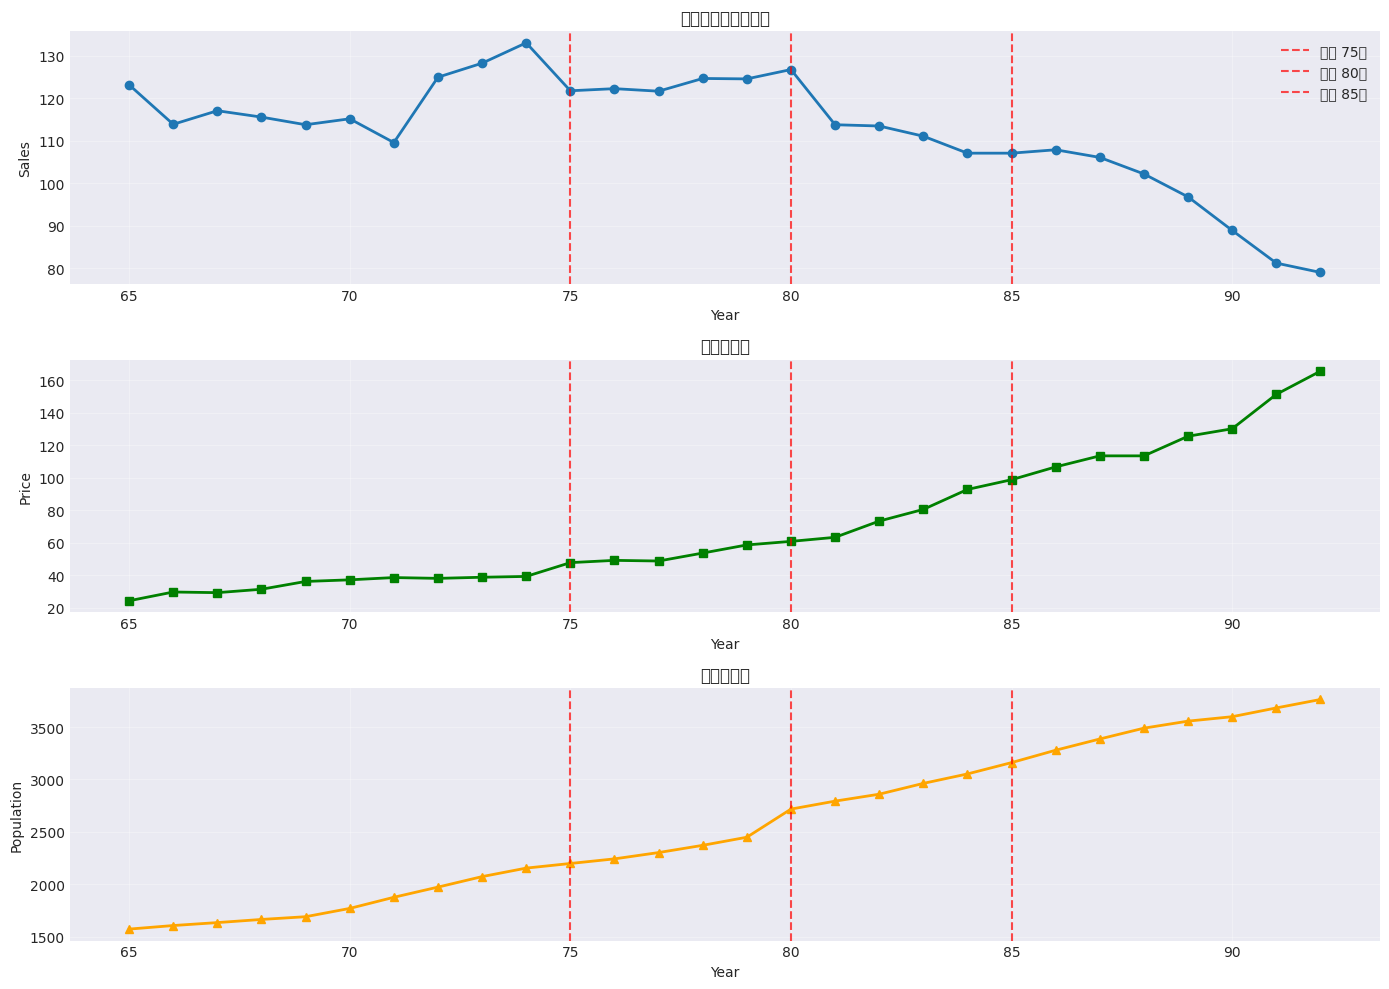

✅ データ可視化完了


In [4]:
# データの可視化
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 販売量の推移
axes[0].plot(cigar_model['year'], cigar_model['sales'], marker='o', linewidth=2)
for intervention in INTERVENTION_POINTS:
    axes[0].axvline(x=intervention, color='red', linestyle='--', alpha=0.7, label=f'介入 {intervention}年')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Sales')
axes[0].set_title('タバコ販売量の推移')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 価格の推移
axes[1].plot(cigar_model['year'], cigar_model['price'], marker='s', color='green', linewidth=2)
for intervention in INTERVENTION_POINTS:
    axes[1].axvline(x=intervention, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price')
axes[1].set_title('価格の推移')
axes[1].grid(True, alpha=0.3)

# 人口の推移
axes[2].plot(cigar_model['year'], cigar_model['pop'], marker='^', color='orange', linewidth=2)
for intervention in INTERVENTION_POINTS:
    axes[2].axvline(x=intervention, color='red', linestyle='--', alpha=0.7)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Population')
axes[2].set_title('人口の推移')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ データ可視化完了")

## 3. モデル1: OLS回帰モデル

最もシンプルなOLS（最小二乗法）回帰モデルで介入効果を推定します。

**モデル式:**
$$
Y_t = \beta_0 + \beta_1 t + \sum_{i=1}^{3} \delta_i D_{i,t} + \sum_{i=1}^{3} \gamma_i (t - T_i) \cdot D_{i,t} + \epsilon_t
$$

- $\delta_i$: 介入 $i$ の即時効果（レベルシフト）
- $\gamma_i$: 介入 $i$ 後のトレンド変化

In [5]:
# OLSモデルの作成
model_ols = ITSModelOLS(
    time_column='year',
    intervention_points=INTERVENTION_POINTS,
    group_column='state'
)

# モデルのフィッティング
model_ols.fit(
    cigar_model,
    target_column='sales',
    covariates=['price', 'pop']
)

print("✅ OLSモデルのフィッティング完了")
print(f"\nモデルサマリー:")
print(model_ols.model_results.summary())

✅ OLSモデルのフィッティング完了

モデルサマリー:
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1536.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           4.28e-24
Time:                        13:48:45   Log-Likelihood:                -66.197
No. Observations:                  28   AIC:                             152.4
Df Residuals:                      18   BIC:                             165.7
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -29.044

In [6]:
# 介入効果の推定
effect_ols = model_ols.calculate_intervention_effect()

print("📊 OLSモデルの介入効果:")
print(effect_ols)

📊 OLSモデルの介入効果:
   state            Period  Actual_mean  Predicted_mean  Counterfactual_mean  \
0      3  Intervention_D_1       123.02          123.02           130.335042   
1      3  Intervention_D_2       114.46          114.46           159.009813   
2      3  Intervention_D_3        96.15           96.15           182.842549   
3      3  Pre-intervention       119.48          119.48           119.480000   

    Effect_mean  
0 -7.315042e+00  
1 -4.454981e+01  
2 -8.669255e+01  
3  4.610001e-12  


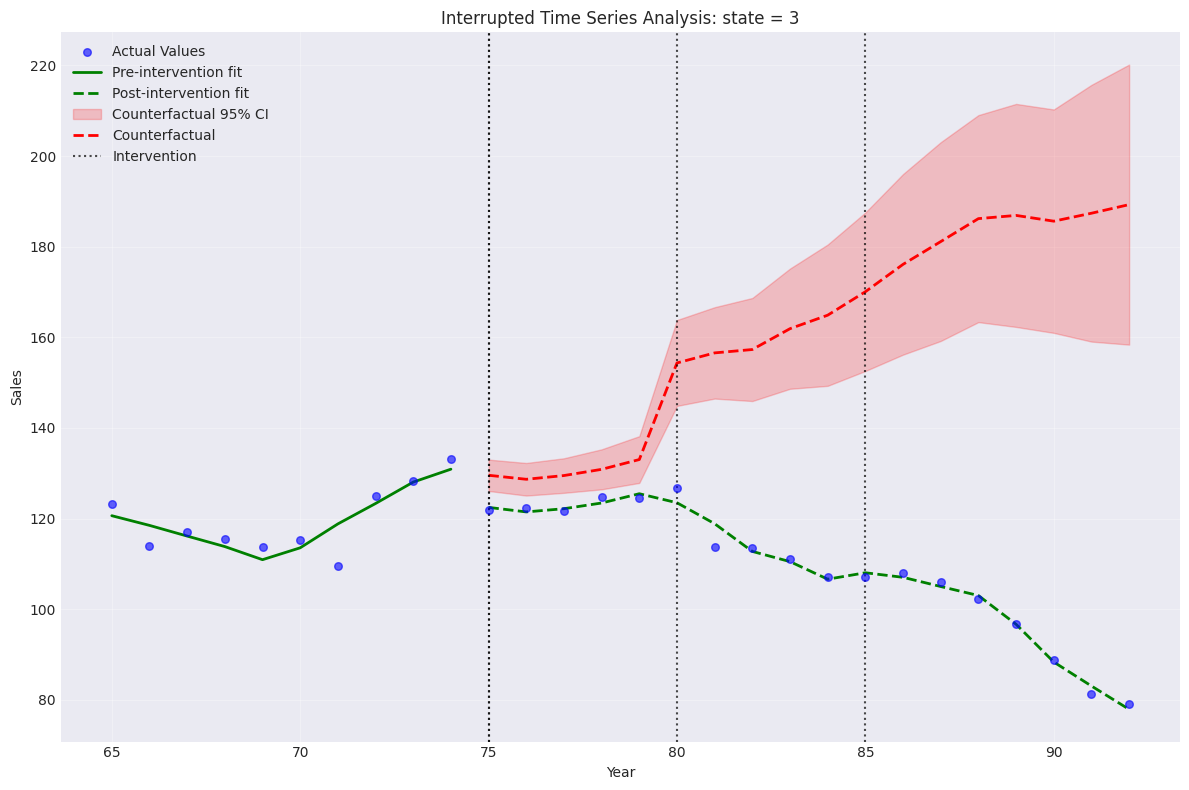

✅ OLSモデルの可視化完了


In [7]:
# OLSモデルの可視化
visualizer_ols = ITSVisualizer(model_ols)
fig_ols = visualizer_ols.plot()
plt.show()

print("✅ OLSモデルの可視化完了")

## 4. モデル2: SARIMAXモデル（Optunaチューニング）

時系列の自己相関を考慮したSARIMAXモデルを構築します。

**重要なポイント:**
- ハイパーパラメータチューニングは**介入前データのみ**で実行
- 介入ダミー変数を除外して最適化（バイアス除去）
- 評価指標: AIC（赤池情報量規準）

In [8]:
# SARIMAXモデルの作成
model_sarimax = ITSModelSARIMAX(
    time_column='year',
    intervention_points=INTERVENTION_POINTS,
    group_column='state'
)

# Optunaによるハイパーパラメータチューニング + フィッティング
print("🔧 Optunaによるハイパーパラメータチューニング中...")
print("（介入前データのみで最適化します）")

model_sarimax.fit(
    cigar_model,
    target_column='sales',
    covariates=['price', 'pop'],
    tune_with_optuna=True,
    n_trials=10  # 実際の分析では50-100推奨
)

print("\n✅ SARIMAXモデルのフィッティング完了")
print(f"最適パラメータ: {model_sarimax.best_params}")
print(f"\nモデルサマリー:")
print(model_sarimax.model_results.summary())

🔧 Optunaによるハイパーパラメータチューニング中...
（介入前データのみで最適化します）


[I 2025-10-13 13:48:45,221] A new study created in memory with name: no-name-2fdd7754-95f8-48ab-8773-fba879250e35


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-13 13:48:45,247] Trial 0 finished with value: 12.0 and parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 0, 's': 12}. Best is trial 0 with value: 12.0.
[I 2025-10-13 13:48:45,250] Trial 1 finished with value: inf and parameters: {'p': 3, 'd': 0, 'q': 3, 'P': 2, 'D': 1, 'Q': 1, 's': 0}. Best is trial 0 with value: 12.0.
[I 2025-10-13 13:48:45,250] Trial 1 finished with value: inf and parameters: {'p': 3, 'd': 0, 'q': 3, 'P': 2, 'D': 1, 'Q': 1, 's': 0}. Best is trial 0 with value: 12.0.
[I 2025-10-13 13:48:45,596] Trial 2 finished with value: 20.0 and parameters: {'p': 3, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 2, 's': 30}. Best is trial 0 with value: 12.0.
[I 2025-10-13 13:48:45,601] Trial 3 finished with value: inf and parameters: {'p': 3, 'd': 2, 'q': 2, 'P': 2, 'D': 1, 'Q': 0, 's': 0}. Best is trial 0 with value: 12.0.
[I 2025-10-13 13:48:45,604] Trial 4 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 's': 0}. Best is trial 0 

In [9]:
# 介入効果の推定
effect_sarimax = model_sarimax.calculate_intervention_effect()

print("📊 SARIMAXモデルの介入効果:")
print(effect_sarimax)

📊 SARIMAXモデルの介入効果:
   state            Period  Actual_mean  Predicted_mean  Counterfactual_mean  \
0      3  Intervention_D_1       123.02      141.026502           171.135283   
1      3  Intervention_D_2       114.46      114.853406           177.644033   
2      3  Intervention_D_3        96.15       95.935479           146.747504   
3      3  Pre-intervention       119.48       98.790426           184.597288   

   Effect_mean  
0   -48.115283  
1   -63.184033  
2   -50.597504  
3   -65.117288  


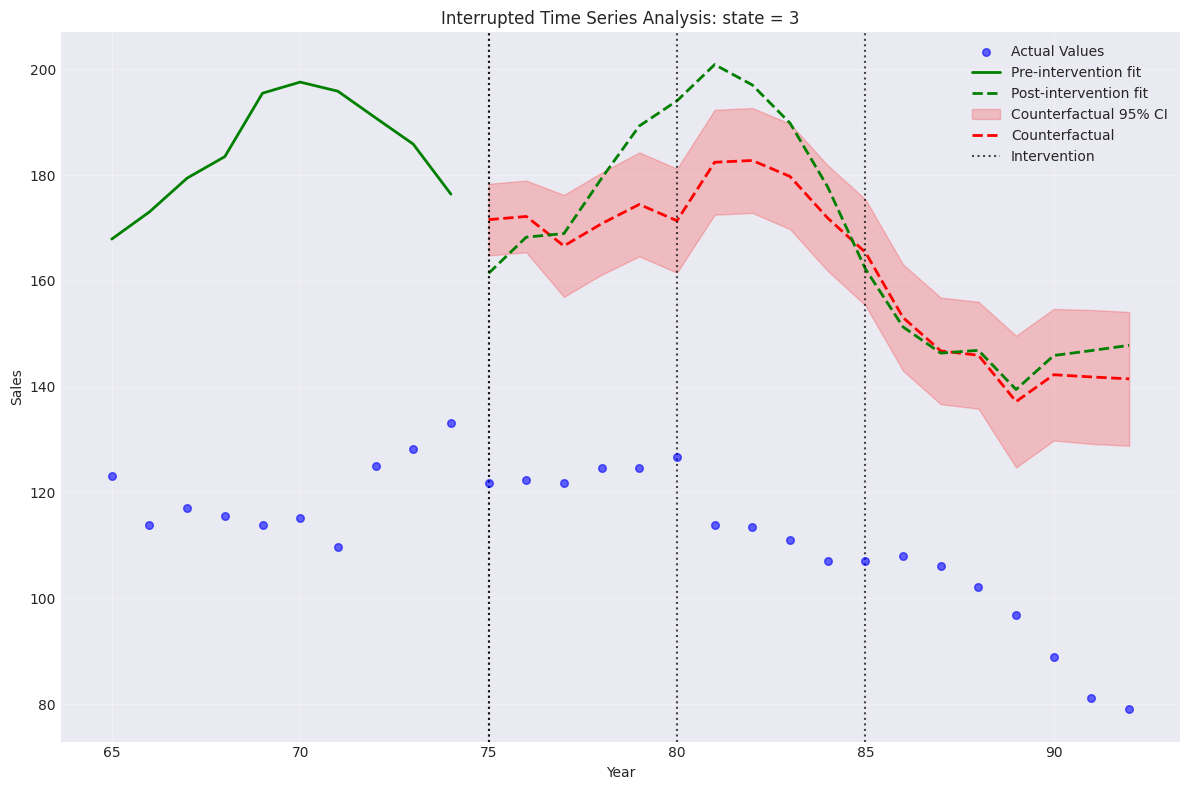

✅ SARIMAXモデルの可視化完了


In [10]:
# SARIMAXモデルの可視化
visualizer_sarimax = ITSVisualizer(model_sarimax)
fig_sarimax = visualizer_sarimax.plot()
plt.show()

print("✅ SARIMAXモデルの可視化完了")

## 5. モデル3: Prophetモデル（Optunaチューニング）

Facebook（Meta）が開発したProphetモデルを使用します。

**特徴:**
- トレンドの変化点を自動検出
- 季節性を柔軟にモデリング
- ベイズ的アプローチで不確実性を定量化
- ハイパーパラメータ: `changepoint_prior_scale`, `n_changepoints`

In [11]:
# Prophetモデルの作成
model_prophet = ITSModelProphet(
    time_column='year',
    intervention_points=INTERVENTION_POINTS,
    group_column='state'
)

# Optunaによるハイパーパラメータチューニング + フィッティング
print("🔧 Optunaによるハイパーパラメータチューニング中...")
print("（介入前データのみで最適化します）")

model_prophet.fit(
    cigar_model,
    target_column='sales',
    tune_with_optuna=True,
    n_trials=10  # 実際の分析では50-100推奨
)

print("\n✅ Prophetモデルのフィッティング完了")
print(f"最適パラメータ: {model_prophet.best_params}")

[I 2025-10-13 13:48:47,398] A new study created in memory with name: no-name-0a46ab8c-4c9a-4542-8a70-300f97141ea8


🔧 Optunaによるハイパーパラメータチューニング中...
（介入前データのみで最適化します）


  0%|          | 0/10 [00:00<?, ?it/s]

13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:47,614] Trial 0 finished with value: 0.10728235653260156 and parameters: {'changepoint_prior_scale': 0.014521846853447025, 'n_changepoints': 7}. Best is trial 0 with value: 0.10728235653260156.


13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:47,806] Trial 1 finished with value: 0.10443295600592255 and parameters: {'changepoint_prior_scale': 0.10190859111643018, 'n_changepoints': 10}. Best is trial 1 with value: 0.10443295600592255.


13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:47,998] Trial 2 finished with value: 0.10786725329318338 and parameters: {'changepoint_prior_scale': 0.033290166869897456, 'n_changepoints': 6}. Best is trial 1 with value: 0.10443295600592255.


13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:48,244] Trial 3 finished with value: 0.10768789504741372 and parameters: {'changepoint_prior_scale': 0.041175042054993935, 'n_changepoints': 15}. Best is trial 1 with value: 0.10443295600592255.


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:48,451] Trial 4 finished with value: 0.1080305702607572 and parameters: {'changepoint_prior_scale': 0.0012190695569834255, 'n_changepoints': 20}. Best is trial 1 with value: 0.10443295600592255.


13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:48,665] Trial 5 finished with value: 0.10801628409462745 and parameters: {'changepoint_prior_scale': 0.001002648859457362, 'n_changepoints': 21}. Best is trial 1 with value: 0.10443295600592255.


13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:48,869] Trial 6 finished with value: 0.10734860702896913 and parameters: {'changepoint_prior_scale': 0.01753962867014428, 'n_changepoints': 13}. Best is trial 1 with value: 0.10443295600592255.

13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:49,086] Trial 7 finished with value: 0.10683468035029069 and parameters: {'changepoint_prior_scale': 0.0055169933370233185, 'n_changepoints': 11}. Best is trial 1 with value: 0.10443295600592255.


13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:49,278] Trial 8 finished with value: 0.08280311132390894 and parameters: {'changepoint_prior_scale': 0.3356199286114881, 'n_changepoints': 22}. Best is trial 8 with value: 0.08280311132390894.


13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-10-13 13:48:49,478] Trial 9 finished with value: 0.0946535043445318 and parameters: {'changepoint_prior_scale': 0.139621203055926, 'n_changepoints': 10}. Best is trial 8 with value: 0.08280311132390894.


13:48:49 - cmdstanpy - INFO - Chain [1] start processing



✅ Prophet最適パラメータ（介入前データでチューニング）:
  changepoint_prior_scale: 0.3356
  n_changepoints: 22
  MAPE: 0.0828


13:48:56 - cmdstanpy - INFO - Chain [1] done processing



✅ Prophetモデルのフィッティング完了
最適パラメータ: {'changepoint_prior_scale': 0.3356199286114881, 'n_changepoints': 22}


In [12]:
# 介入効果の推定
effect_prophet = model_prophet.calculate_intervention_effect()

print("📊 Prophetモデルの介入効果:")
print(effect_prophet)

📊 Prophetモデルの介入効果:
   state            Period  Actual_mean  Predicted_mean  Counterfactual_mean  \
0      3  Intervention_D_1       123.02      123.019784           136.302178   
1      3  Intervention_D_2       114.46      114.459700           120.155748   
2      3  Intervention_D_3        96.15       96.149633           138.141280   
3      3  Pre-intervention       119.48      119.479968           119.479968   

   Effect_mean  
0   -13.282178  
1    -5.695748  
2   -41.991280  
3     0.000032  


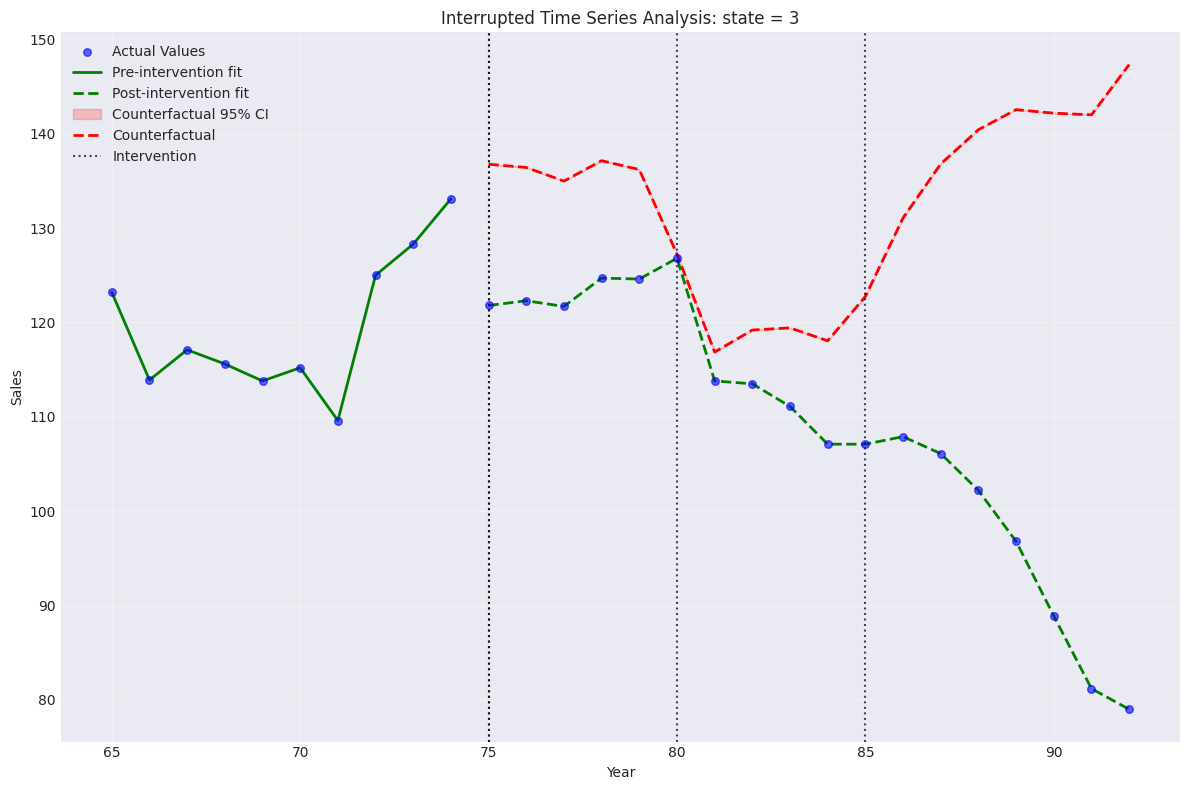

✅ Prophetモデルの可視化完了


In [13]:
# Prophetモデルの可視化
visualizer_prophet = ITSVisualizer(model_prophet)
fig_prophet = visualizer_prophet.plot()
plt.show()

print("✅ Prophetモデルの可視化完了")

## 6. モデル検証: プラセボクロスバリデーション

モデルの信頼性を検証するため、プラセボクロスバリデーション（Placebo Cross-Validation）を実施します。

**プラセボCVとは？**
- 介入前期間に仮想的な介入点（プラセボ介入点）を設定
- 本来効果がないはずの期間で効果を検出してしまう場合、モデルに問題がある
- p値 > 0.05 であれば、モデルは偽陽性を検出していない（= 信頼できる）

### 6.1 単一介入のプラセボCV（OLSモデル）

In [14]:
# OLSモデルでプラセボCV実行
print("🔍 OLSモデルのプラセボクロスバリデーション実行中...")

placebo_result_ols = model_ols.placebo_cross_validate(
    df=cigar_model,
    target_column='sales',
    n_placebo_points=5,
    covariates=['price', 'pop']
)

print("\n📊 プラセボCV結果:")
print(f"プラセボテスト数: {placebo_result_ols['n_placebo_tests']}")
print(f"平均プラセボ効果: {placebo_result_ols['mean_placebo_effect']:.4f}")
print(f"標準偏差: {placebo_result_ols['std_placebo_effect']:.4f}")
print(f"p値: {placebo_result_ols['p_value']:.4f}")
print(f"判定: {'✅ 合格（偽陽性なし）' if placebo_result_ols['is_valid'] else '⚠️ 注意（偽陽性の可能性）'}")

print(f"\nプラセボ介入点: {placebo_result_ols['placebo_points']}")
print(f"各プラセボ効果: {placebo_result_ols['placebo_effects']}")

🔍 OLSモデルのプラセボクロスバリデーション実行中...

📊 プラセボCV結果:
プラセボテスト数: 5
平均プラセボ効果: 5.6442
標準偏差: 22.7323
p値: 0.6455
判定: ✅ 合格（偽陽性なし）

プラセボ介入点: [np.float64(66.5), np.float64(68.0), np.float64(69.5), np.float64(71.0), np.float64(72.5)]
各プラセボ効果: [np.float64(-26.444814296794455), np.float64(14.21776187851338), np.float64(42.396630437981514), np.float64(-5.568803108093096), np.float64(3.6200462738435846)]


### 6.2 複数介入のプラセボCV

複数の介入がある場合、それぞれの介入について独立にプラセボCVを実行できます。

In [15]:
# 複数介入のプラセボCV（SARIMAXモデル）
print("🔍 SARIMAXモデルの複数介入プラセボCV実行中...")

placebo_multi_result = model_sarimax.placebo_cv_multiple_interventions(
    df=cigar_model,
    target_column='sales',
    n_placebo_per_intervention=3,
    covariates=['price', 'pop']
)

print("\n📊 複数介入プラセボCV結果:")
print(placebo_multi_result)

🔍 SARIMAXモデルの複数介入プラセボCV実行中...
警告: 介入2の前のデータが少なすぎます（5サンプル）。スキップします。
警告: 介入3の前のデータが少なすぎます（5サンプル）。スキップします。

【複数介入プラセボCV結果】

介入 1: 75
  プラセボ効果の平均: -13.165
  プラセボ効果の標準偏差: 1.754
  t検定 p値: 0.009
  → ⚠️ モデルに問題の可能性

📊 複数介入プラセボCV結果:
   real_intervention_index  real_intervention_point  placebo_point  \
0                        0                       75          67.25   
1                        0                       75          69.50   
2                        0                       75          71.75   

   placebo_effect  placebo_effect_std  
0      -10.690107                 NaN  
1      -14.261388                 NaN  
2      -14.542912                 NaN  
警告: 介入2の前のデータが少なすぎます（5サンプル）。スキップします。
警告: 介入3の前のデータが少なすぎます（5サンプル）。スキップします。

【複数介入プラセボCV結果】

介入 1: 75
  プラセボ効果の平均: -13.165
  プラセボ効果の標準偏差: 1.754
  t検定 p値: 0.009
  → ⚠️ モデルに問題の可能性

📊 複数介入プラセボCV結果:
   real_intervention_index  real_intervention_point  placebo_point  \
0                        0                       75          67.25   
1  

### 6.3 感度分析CV

時間窓のサイズを変えながら、結果の頑健性を確認します。

In [16]:
# 感度分析CV（Prophetモデル）
print("🔍 Prophetモデルの感度分析CV実行中...")

sensitivity_result = model_prophet.sensitivity_analysis_cv(
    df=cigar_model,
    target_column='sales',
    window_sizes=[0.5, 0.7, 0.9]  # 介入前データの50%, 70%, 90%を使用
)

print("\n📊 感度分析CV結果:")
print(sensitivity_result)

🔍 Prophetモデルの感度分析CV実行中...
警告: 窓サイズ(12, 12)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(12, 12)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(12, 12)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(18, 12)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(18, 12)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(18, 12)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(12, 18)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(12, 18)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(12, 18)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_sizes'
警告: 窓サイズ(24, 12)でのフィット失敗: ITSModelProphet.fit() got an unexpected keyword argument 'window_s

### 6.4 全モデルのプラセボCV比較

In [17]:
# 全モデルでプラセボCVを実行して比較
print("🔍 全モデルのプラセボCVを実行中...\n")

models = {
    'OLS': model_ols,
    'SARIMAX': model_sarimax,
    'Prophet': model_prophet
}

placebo_results = {}

for model_name, model in models.items():
    print(f"--- {model_name} モデル ---")
    result = model.placebo_cross_validate(
        df=cigar_model,
        target_column='sales',
        n_placebo_points=5,
        covariates=['price', 'pop'] if model_name != 'Prophet' else None
    )
    placebo_results[model_name] = result
    print(f"p値: {result['p_value']:.4f}")
    print(f"判定: {'✅ 合格' if result['is_valid'] else '⚠️ 注意'}\n")

# 結果を表にまとめる
comparison_df = pd.DataFrame({
    'Model': list(placebo_results.keys()),
    'Mean Effect': [r['mean_placebo_effect'] for r in placebo_results.values()],
    'Std Dev': [r['std_placebo_effect'] for r in placebo_results.values()],
    'p-value': [r['p_value'] for r in placebo_results.values()],
    'Valid': [r['is_valid'] for r in placebo_results.values()]
})

print("\n📊 プラセボCV結果比較:")
print(comparison_df.to_string(index=False))

🔍 全モデルのプラセボCVを実行中...

--- OLS モデル ---
p値: 0.6455
判定: ✅ 合格

--- SARIMAX モデル ---


13:48:58 - cmdstanpy - INFO - Chain [1] start processing
13:48:58 - cmdstanpy - INFO - Chain [1] done processing
13:48:58 - cmdstanpy - INFO - Chain [1] done processing
13:48:58 - cmdstanpy - INFO - Chain [1] start processing
13:48:58 - cmdstanpy - INFO - Chain [1] start processing
13:48:58 - cmdstanpy - INFO - Chain [1] done processing
13:48:58 - cmdstanpy - INFO - Chain [1] done processing


p値: 0.0002
判定: ⚠️ 注意

--- Prophet モデル ---


13:48:59 - cmdstanpy - INFO - Chain [1] start processing
13:48:59 - cmdstanpy - INFO - Chain [1] done processing
13:48:59 - cmdstanpy - INFO - Chain [1] done processing
13:48:59 - cmdstanpy - INFO - Chain [1] start processing
13:48:59 - cmdstanpy - INFO - Chain [1] start processing
13:48:59 - cmdstanpy - INFO - Chain [1] done processing
13:48:59 - cmdstanpy - INFO - Chain [1] done processing
13:48:59 - cmdstanpy - INFO - Chain [1] start processing
13:48:59 - cmdstanpy - INFO - Chain [1] start processing
13:48:59 - cmdstanpy - INFO - Chain [1] done processing
13:48:59 - cmdstanpy - INFO - Chain [1] done processing


p値: 0.0297
判定: ⚠️ 注意


📊 プラセボCV結果比較:
  Model  Mean Effect   Std Dev  p-value  Valid
    OLS     5.644164 22.732270 0.645538   True
SARIMAX   -14.295111  2.243730 0.000219  False
Prophet    21.344976 12.902957 0.029695  False


## 7. 結果の比較と解釈

3つのモデルの介入効果推定値を比較し、結果の頑健性を確認します。

📊 介入効果の比較

                           OLS    SARIMAX    Prophet
Intervention_D_1 -7.315042e+00 -48.115283 -13.282178
Intervention_D_2 -4.454981e+01 -63.184033  -5.695748
Intervention_D_3 -8.669255e+01 -50.597504 -41.991280
Pre-intervention  4.610001e-12 -65.117288   0.000032


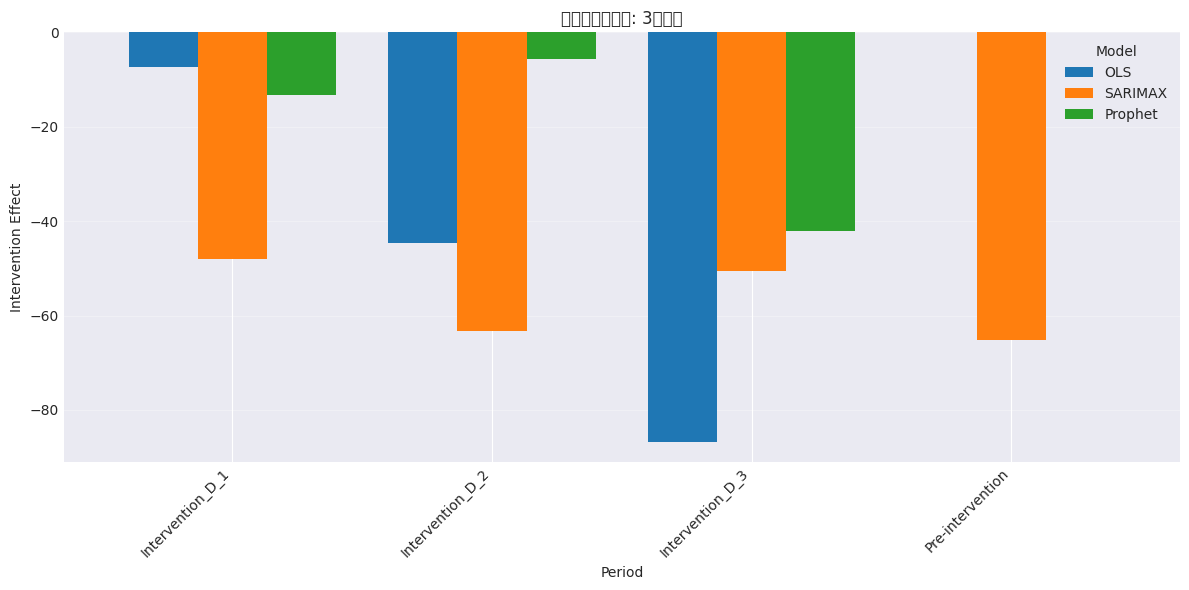


✅ 結果比較完了


In [18]:
# 介入効果の比較
print("📊 介入効果の比較\n")

effects_comparison = pd.DataFrame({
    'OLS': effect_ols['Effect_mean'].values,
    'SARIMAX': effect_sarimax['Effect_mean'].values,
    'Prophet': effect_prophet['Effect_mean'].values
}, index=effect_ols['Period'].values)

print(effects_comparison)

# 可視化
fig, ax = plt.subplots(figsize=(12, 6))
effects_comparison.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Period')
ax.set_ylabel('Intervention Effect')
ax.set_title('介入効果の比較: 3モデル')
ax.legend(title='Model')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✅ 結果比較完了")

## 8. レポート生成

分析結果を包括的なMarkdownレポートとして出力します。

**レポート内容:**
- モデル特定化の詳細説明
- 介入効果の推定値と標準誤差
- プラセボクロスバリデーション結果
- 可視化結果への参照
- 考察セクション（要記入）

In [19]:
# モデルの保存（オプション）
import pickle
from pathlib import Path

# モデル保存ディレクトリの作成
models_dir = Path.cwd().parent / 'models'
models_dir.mkdir(exist_ok=True)

# 各モデルを保存
model_files = {
    'its_model_ols.pkl': model_ols,
    'its_model_sarimax_tuned.pkl': model_sarimax,
    'its_model_prophet_tuned.pkl': model_prophet
}

for filename, model in model_files.items():
    filepath = models_dir / filename
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ 保存: {filepath}")

print("\n全モデルの保存が完了しました")

✅ 保存: /home/kien/Desktop/learning_Python/Interrupted_Time_Series_Design/models/its_model_ols.pkl
✅ 保存: /home/kien/Desktop/learning_Python/Interrupted_Time_Series_Design/models/its_model_sarimax_tuned.pkl
✅ 保存: /home/kien/Desktop/learning_Python/Interrupted_Time_Series_Design/models/its_model_prophet_tuned.pkl

全モデルの保存が完了しました


In [20]:
# レポート生成スクリプトの実行
# 注: generate_report.pyは保存されたモデルを読み込んで包括的なレポートを生成します

print("📄 分析レポートを生成中...")
print("\nレポート生成には以下のコマンドを実行してください:")
print("  python src/generate_report.py")
print("\n生成されるレポート:")
print("  - output/analysis_report.md")
print("\n内容:")
print("  1. モデル特定化の詳細")
print("  2. 介入効果の推定結果（回帰係数と標準誤差）")
print("  3. プラセボクロスバリデーション結果")
print("  4. 可視化結果")
print("  5. 結論と考察セクション")

📄 分析レポートを生成中...

レポート生成には以下のコマンドを実行してください:
  python src/generate_report.py

生成されるレポート:
  - output/analysis_report.md

内容:
  1. モデル特定化の詳細
  2. 介入効果の推定結果（回帰係数と標準誤差）
  3. プラセボクロスバリデーション結果
  4. 可視化結果
  5. 結論と考察セクション


## まとめ

このノートブックでは、断続的時系列分析（ITS）パッケージの全機能を紹介しました。

### 🎯 実施した分析

1. **データ読み込みと前処理**: Cigarデータセット、3つの介入点
2. **OLSモデル**: 基本的な回帰分析
3. **SARIMAXモデル**: 自己相関を考慮、Optunaによるハイパーパラメータ最適化
4. **Prophetモデル**: トレンド変化点の自動検出、ベイズ的アプローチ
5. **プラセボCV**: モデル検証（単一介入、複数介入、感度分析）
6. **結果比較**: 3モデルの介入効果推定値の比較
7. **レポート生成**: 包括的なMarkdownレポートの作成

### 💡 重要なポイント

- **ハイパーパラメータチューニング**: 介入前データのみで実行してバイアスを除去
- **プラセボCV**: p値 > 0.05 でモデルの信頼性を確認
- **多角的評価**: 3つの異なるモデルで結果の頑健性を検証

### 📚 次のステップ

- より多くのn_trialsでハイパーパラメータ最適化を実行（推奨: 50-100）
- 異なるデータセットで分析を試す
- 感度分析で時間窓のサイズを変えて頑健性を確認
- 生成されたレポートに考察を追記

---
